In [1]:
import pandas as pd

In [2]:
# Make use of pandas to open up the 'foreveralone.xlsx'
foreveralone = pd.read_excel('foreveralone(final).xlsx')

In [3]:
# let's take a look at the previously cleaned dataset and see whether need to simplify it further
foreveralone.head()

,time,gender,sexuallity,age,income,race,bodyweight,virgin,prostitution_legal,pay_for_sex,...,what_help_from_others,attempt_suicide,employment,job_title,edu_level,improve_yourself_how,job_title_cleaned,edu_level_cleaned,income_category,generation
0,5/17/2016 20:04:18,Male,Straight,35,"$30,000 to $39,999",Caucasian,Normal weight,1,0,0,...,"wingman/wingwoman, Set me up with a date",1,Employed for wages,mechanical drafter,Associate degree,No response,mechanical drafter,Associate degree,Low Income,Millennial
1,5/17/2016 20:04:30,Male,Bisexual,21,"$1 to $10,000",Caucasian,Underweight,1,0,0,...,"wingman/wingwoman, Set me up with a date, date...",0,Out of work and looking for work,-,"Some college, no degree",join clubs/socual clubs/meet ups,unknown,"Some college, no degree",Very Low Income,Gen Z
2,5/17/2016 20:04:58,Male,Straight,22,$0,Caucasian,Overweight,1,0,0,...,I don't want help,0,Out of work but not currently looking for work,unemployed,"Some college, no degree",Other exercise,unemployed,"Some college, no degree",No Income,Gen Z
3,5/17/2016 20:08:01,Male,Straight,19,"$1 to $10,000",Caucasian,Overweight,1,1,0,...,date coaching,0,A student,student,"Some college, no degree",Joined a gym/go to the gym,student,"Some college, no degree",Very Low Income,Gen Z
4,5/17/2016 20:08:04,Male,Straight,23,"$30,000 to $39,999",Caucasian,Overweight,0,0,1,...,I don't want help,0,Employed for wages,Factory worker,"High school graduate, diploma or the equivalen...",No response,factory worker,"High school graduate, diploma or the equivalen...",Low Income,Gen Z


In [4]:
# Drop columns which features I would not use later as not related to demographic feature analysis.
# Some features such as 'pay_for_sex', 'what_help_from_others', and 'improve_yourself_how', are related to behavior
# while 'social_fear', 'depressed' are referring to psychological state so will be removed as well.

demographic_features = foreveralone.drop(columns=['time','age','virgin','prostitution_legal','pay_for_sex','friends','social_fear','depressed','what_help_from_others','attempt_suicide','job_title_cleaned','job_title','edu_level','income_category','improve_yourself_how'])

# Encoding categorical values to numerical values for clustering and other machine learning modeling

Have identify the following demographic features in dataset as primary demographic features to be used in clustering.

Gender
Sexuality
Age
Income
Race
Bodyweight
Job_Title_Cleaned
Edu_Level_Cleaned
Generation


In [5]:
# Check which are categorical and which are numerical values

demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             469 non-null    object
 1   sexuallity         469 non-null    object
 2   income             469 non-null    object
 3   race               469 non-null    object
 4   bodyweight         469 non-null    object
 5   employment         469 non-null    object
 6   edu_level_cleaned  469 non-null    object
 7   generation         469 non-null    object
dtypes: object(8)
memory usage: 29.4+ KB


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Define primary demographic features identified
primary_features = ['gender', 'sexuallity', 'race', 'bodyweight',
                    'employment', 'edu_level_cleaned', 'generation']

# Process categorical variables using label encoding
label_encoders = {}
for feature in primary_features:
    if demographic_features[feature].dtype == 'object':  # Check if the feature is categorical
        le = LabelEncoder()
        demographic_features[feature] = le.fit_transform(demographic_features[feature])
        label_encoders[feature] = le

# Pre-process ordinal variable 'income' using Ordinal Encoding
income_categories = [
    '$0', 
    '$1 to $10,000', 
    '$10,000 to $19,999', 
    '$20,000 to $29,999', 
    '$30,000 to $39,999', 
    '$40,000 to $49,999', 
    '$50,000 to $74,999', 
    '$75,000 to $99,999', 
    '$100,000 to $124,999', 
    '$125,000 to $149,999', 
    '$150,000 to $174,999', 
    '$174,999 to $199,999', 
    '$200,000 or more'
]

ordinal_encoder = OrdinalEncoder(categories=[income_categories])
demographic_features['income'] = ordinal_encoder.fit_transform(demographic_features[['income']])

# Save the encoded dataset to a new CSV file
demographic_features.to_csv('demographic_features.csv', index=False)
print("Encoded dataset saved to 'demographic_features.csv'")

# Create and save label encoding mappings
label_mappings = {}
for feature in primary_features:
    if feature in label_encoders:
        le = label_encoders[feature]
        mappings = dict(zip(le.transform(le.classes_), le.classes_))
        label_mappings[feature] = mappings

# Add ordinal encoding mapping for income
income_mapping = dict(enumerate(income_categories))
label_mappings['income'] = income_mapping

# Convert mappings to DataFrames
mapping_dfs = {feature: pd.DataFrame(list(mappings.items()), columns=['Encoded', 'Original']) 
               for feature, mappings in label_mappings.items()}

# Save each mapping to a separate CSV file
for feature, mapping_df in mapping_dfs.items():
    mapping_df.to_csv(f'{feature}_label_mapping.csv', index=False)

print("Label encoding mappings saved to CSV files.")


Encoded dataset saved to 'demographic_features.csv'
Label encoding mappings saved to CSV files.


# Clustering Model

In [7]:
# Add libraries required

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

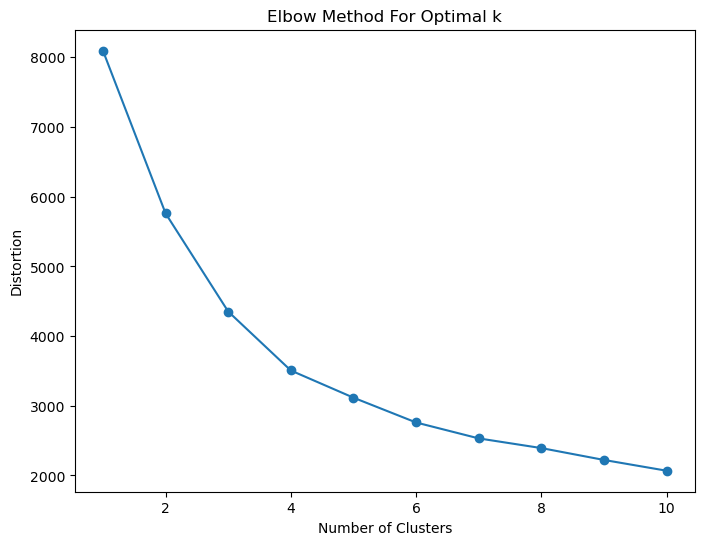

In [8]:
import warnings
# Ignore warnings (added after run as there are too many warnings to read before getting to chart)
warnings.filterwarnings('ignore')

# Define elbow method to determine the optimal number of clusters
def plot_elbow_method(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

# Plot elbow method to find optimal number of clusters
plot_elbow_method(demographic_features)

# Determine the optimal number of clusters using the elbow method
def plot_elbow_method(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans

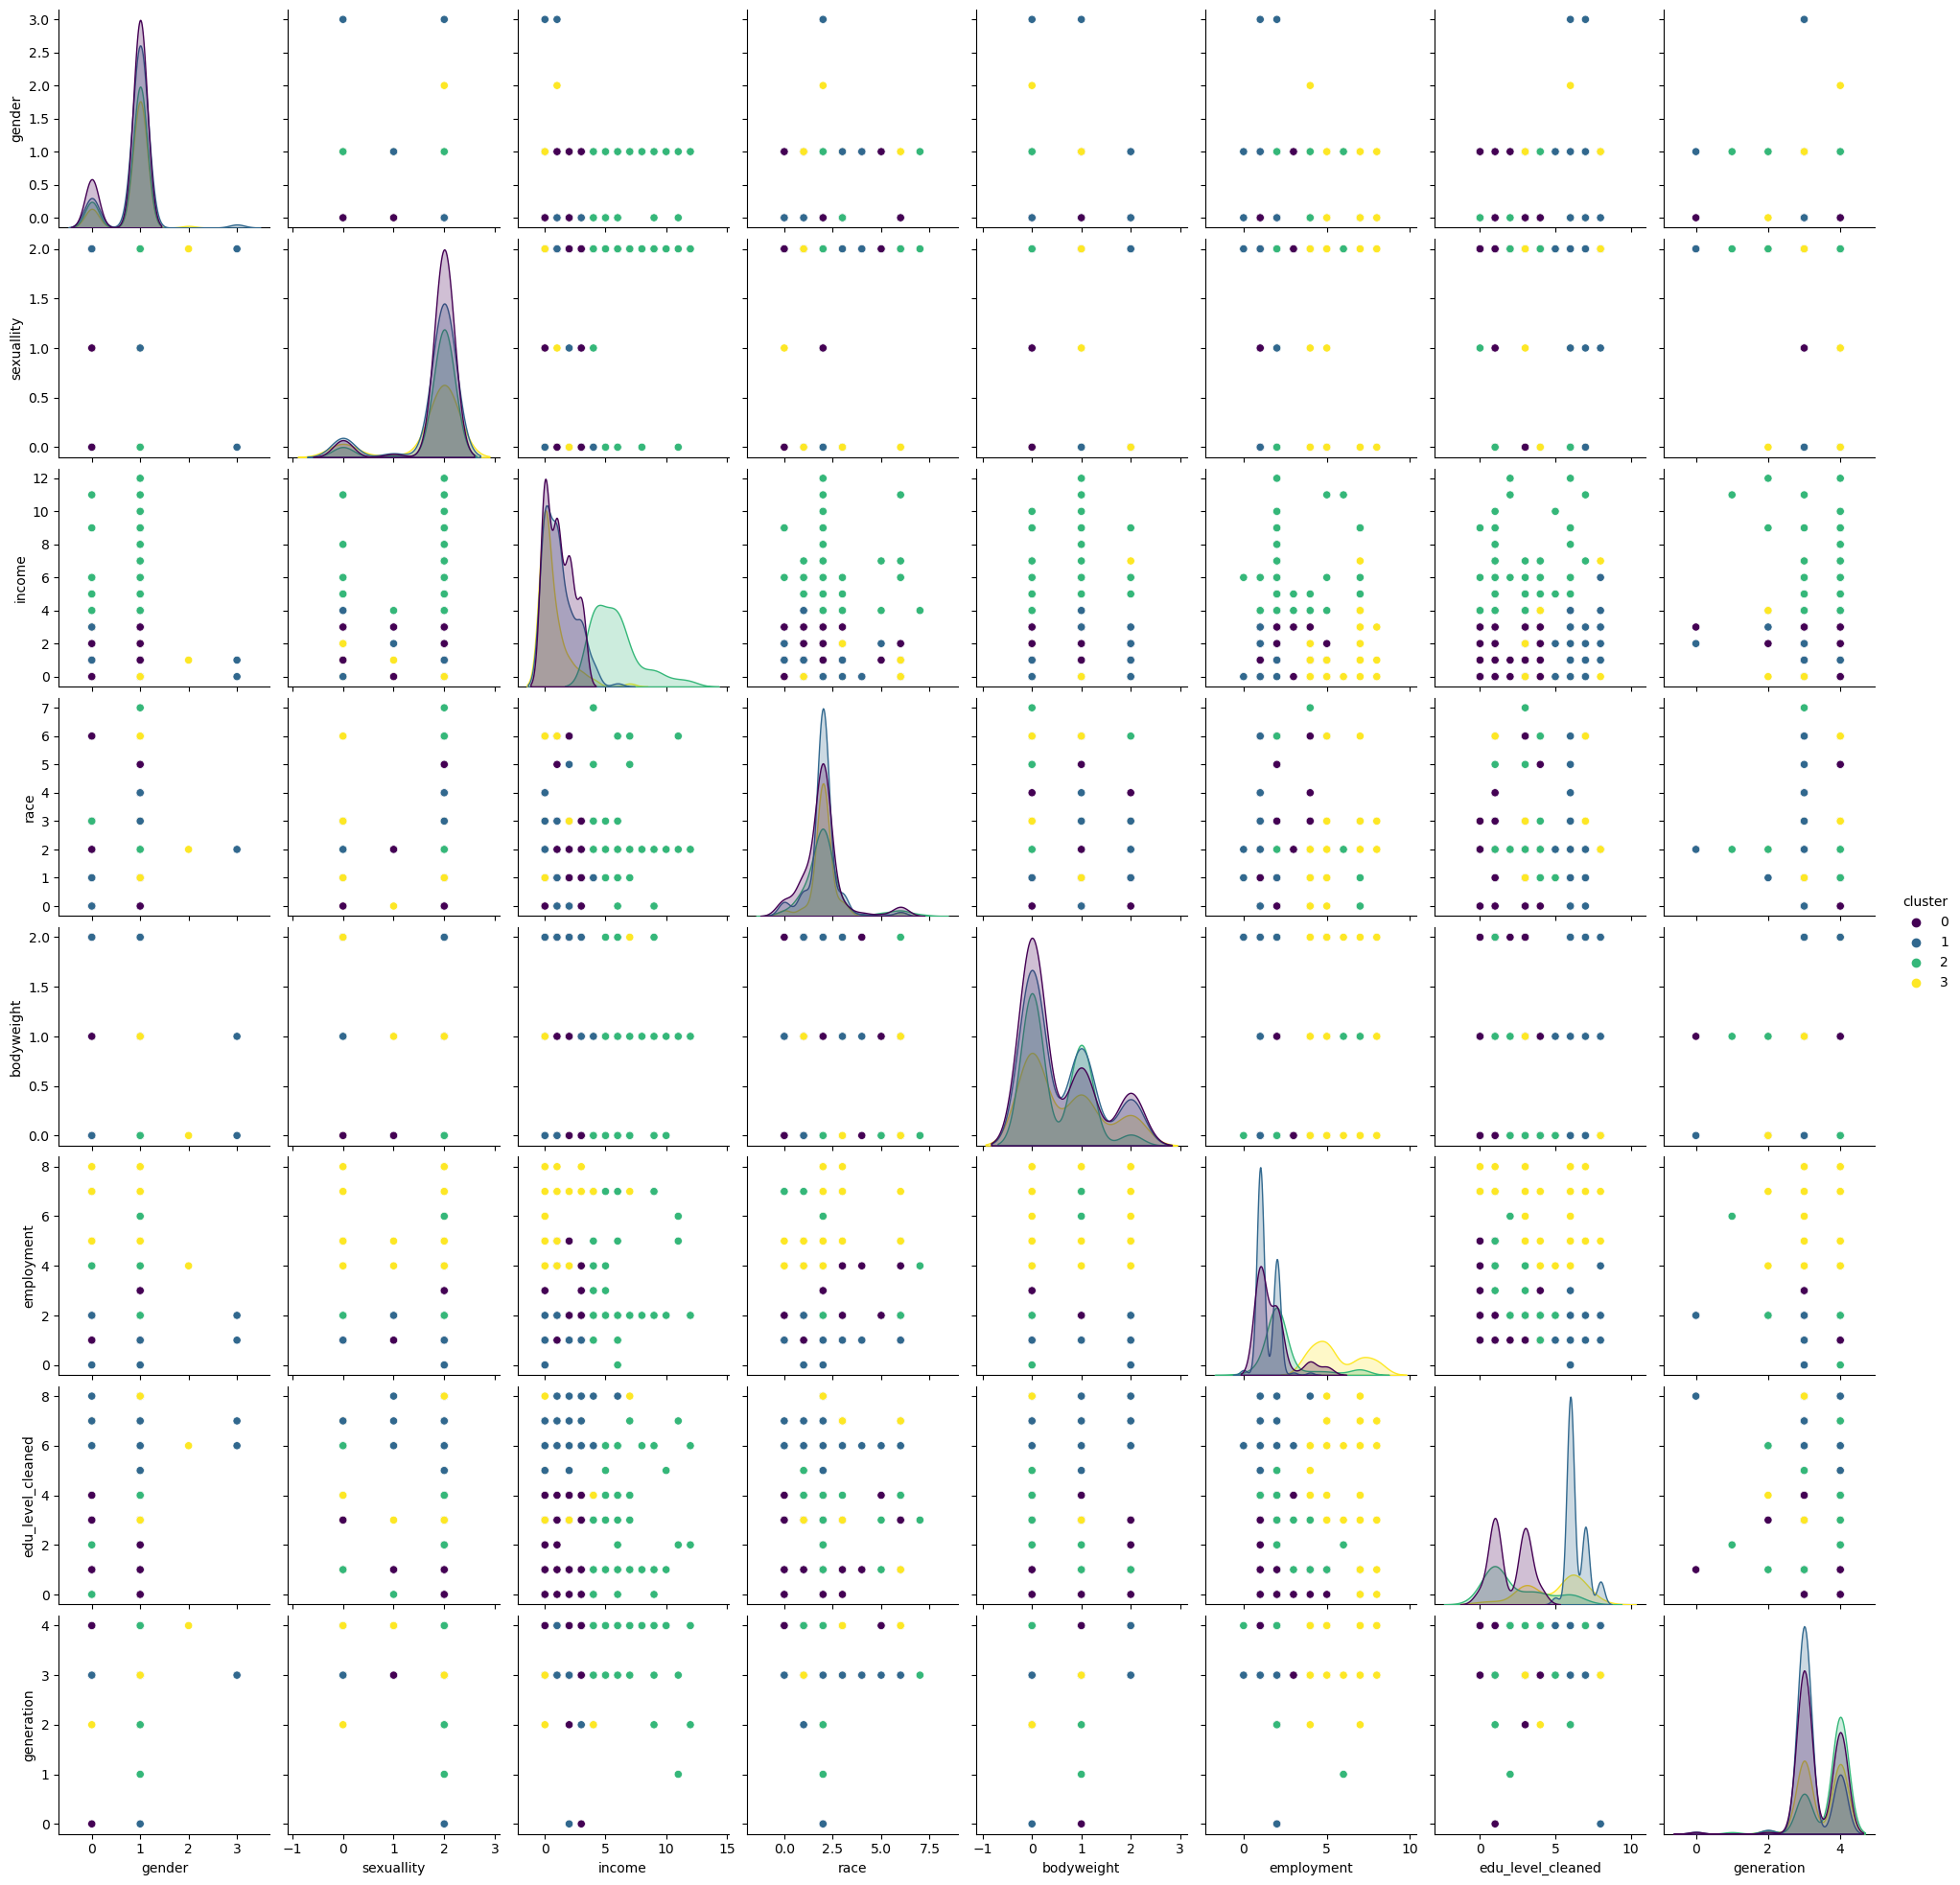

In [9]:
# From above graph using elbow method, 4 is the optimal number of clusters identified.
kmeans = KMeans(n_clusters=4, random_state=42)
demographic_features['cluster'] = kmeans.fit_predict(demographic_features)

# Visualize the clusters. Used pairwise feature plots as there are too many features (8 features in total) to plot
sns.pairplot(demographic_features, hue='cluster', palette='viridis')
plt.show()

In [10]:
# Save the clustered dataset
demographic_features.to_csv('primary_clustered.csv', index=False)

print("Clustering complete. Clustered dataset saved to 'primary_clustered.csv'")

Clustering complete. Clustered dataset saved to 'primary_clustered.csv'


# Examine the clusters to identify target groups

In [11]:
# Load the clustered dataset
df_clustered = pd.read_csv('primary_clustered.csv')

# Inspect the first few rows
df_clustered.head()


,gender,sexuallity,income,race,bodyweight,employment,edu_level_cleaned,generation,cluster
0,1,2,4.0,2,0,2,0,4,2
1,1,0,1.0,2,2,4,6,3,3
2,1,2,0.0,2,1,5,6,3,3
3,1,2,1.0,2,1,1,6,3,1
4,1,2,4.0,2,1,2,3,3,2


In [12]:
# Get basic statistics of the features for each cluster
print(df_clustered.groupby('cluster').describe())

        gender                                              sexuallity  \
         count      mean       std  min  25%  50%  75%  max      count   
cluster                                                                  
0        148.0  0.810811  0.392989  0.0  1.0  1.0  1.0  1.0      148.0   
1        138.0  0.891304  0.430325  0.0  1.0  1.0  1.0  3.0      138.0   
2         97.0  0.845361  0.363439  0.0  1.0  1.0  1.0  1.0       97.0   
3         86.0  0.883721  0.357067  0.0  1.0  1.0  1.0  2.0       86.0   

                   ... edu_level_cleaned      generation                      \
             mean  ...               75%  max      count      mean       std   
cluster            ...                                                         
0        1.837838  ...               3.0  4.0      148.0  3.351351  0.569818   
1        1.760870  ...               7.0  8.0      138.0  3.181159  0.515957   
2        1.845361  ...               4.0  7.0       97.0  3.680412  0.569107   
3

In [13]:
# Frequency distribution of categorical features within each cluster
categorical_features = ['gender', 'sexuallity', 'income', 'race', 'bodyweight', 'employment', 'edu_level_cleaned', 'generation']

for feature in categorical_features:
    print(df_clustered.groupby('cluster')[feature].value_counts(normalize=True).unstack())


gender          0         1         2         3
cluster                                        
0        0.189189  0.810811       NaN       NaN
1        0.137681  0.847826       NaN  0.014493
2        0.154639  0.845361       NaN       NaN
3        0.127907  0.860465  0.011628       NaN
sexuallity         0         1         2
cluster                                 
0           0.074324  0.013514  0.912162
1           0.108696  0.021739  0.869565
2           0.072165  0.010309  0.917526
3           0.151163  0.023256  0.825581
income       0.0       1.0       2.0       3.0       4.0       5.0       6.0   \
cluster                                                                         
0        0.358108  0.277027  0.216216  0.148649       NaN       NaN       NaN   
1        0.369565  0.311594  0.137681  0.130435  0.043478       NaN  0.007246   
2             NaN       NaN       NaN       NaN  0.319588  0.164948  0.278351   
3        0.651163  0.186047  0.081395  0.046512  0.023256    

In [14]:
from sklearn.cluster import KMeans

# Re-run KMeans to get cluster centers
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_clustered.drop('cluster', axis=1))
centers = kmeans.cluster_centers_

# Create a DataFrame for cluster centers
cluster_centers_df = pd.DataFrame(centers, columns=df_clustered.drop('cluster', axis=1).columns)

# Print cluster centers
print(cluster_centers_df)


     gender  sexuallity    income      race  bodyweight  employment  \
0  0.810811    1.837838  1.155405  1.966216    0.540541    1.722973   
1  0.891304    1.760870  1.195652  1.985507    0.594203    1.369565   
2  0.845361    1.845361  5.835052  2.134021    0.463918    2.432990   
3  0.883721    1.674419  0.662791  2.058140    0.639535    5.569767   

   edu_level_cleaned  generation  
0           1.972973    3.351351  
1           6.369565    3.181159  
2           2.329897    3.680412  
3           4.906977    3.453488  


Let's decode and find our target groups!